This code utilizes a python empirical mode decomposition library. See the documentation here: https://emd.readthedocs.io/en/stable/index.html

Install this package with !pip install emd from within a Jupyter notebook, or simply with "pip install emd" from the standard command line. One small note, you may have to downgrade the version of numpy that you have installed in the version to allow this code to work. This can be done with pip install numpy==1.26.4 as that is the version that I have installed for my environment.

Note: this is the library was utilized for the empirical mode decomposition of seismic signals a few years back.

This notebook will contain the basic functionality to process, visualize, and create .wav files by utilizing the EMD process and generation IMFs for a given signal.

There are 2 separate notebooks that are essentially designed to accomplish the same task, only using different implementations of an EMD approach as to compare the results from both.

This is the library that was used for all preliminary tests and examples (extraScenarios_emd.zip) and the results generated with this approach will be in a directory titled emd_Results, whereas results using the PyEMD library will be in a directory titled PyEMD_Results.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import emd
import os
from glob import glob

In [2]:
os.chdir('C:\\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED')

In [112]:
#This code is only here if you are attempting to work with a signal that as been broken into frames, as in the ESCAPE_II_ONECHANNEL_PROCESSED
#directory, this allows you to get all of the segments for on specific original file and reconstruct the full signal for processing
#or you can take a subset of an original and reconstruct just the first 30 seconds for example and use that as your original

# signal = glob('d306sA2r25p03*')
# combined_signal = []
# for wav_file in focus:
#     y, sr = librosa.load(wav_file, sr=None)  # Load the WAV file
#     combined_signal.append(y)  # Append the audio data to the list

# # Concatenate all audio arrays into one
# combined_signal = np.concatenate(combined_signal)
# sf.write(f'C:\\Users\Alec\Desktop\GriffinEMD\currentTest\workingSignal.wav', combined_signal, sr)

In [12]:
y,sr = librosa.load("C:\\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL\sA3r04\p04\d308\d308sA3r04p0420210827.wav", sr=None)

In [13]:
#code to run the sifting process and generate the imfs. See: https://emd.readthedocs.io/en/stable/api.html#sift-functions
imf_opts = {}
imf = emd.sift.sift(y, imf_opts=imf_opts)
print(imf.shape)

(5760001, 9)


In [30]:
#plot the IMFs 
num_columns = imf.shape[1]

# Create figure and axes
fig, axes = plt.subplots(num_columns, 1, figsize=(10, 8), sharex=True)

# Iterate over columns and plot
for i in range(num_columns):
    axes[i].plot(imf[:, i], label=f'IMF {i+1}')
    axes[i].legend()

# Set common x-axis label
axes[-1].set_xlabel('Index')

plt.tight_layout()
plt.show()

C:\Users\Alec\AppData\Local\Temp\ipykernel_20212\1848959690.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Alec\.conda\envs\slopeWork\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)

KeyboardInterrupt



In [143]:
#code to generate the instantaneous frequency, I do not fully understand this, added code from the documentation tutorial
#See: https://emd.readthedocs.io/en/stable/emd_tutorials/02_spectrum_analysis/emd_tutorial_02_spectrum_01_hilberthuang.html#sphx-glr-emd-tutorials-02-spectrum-analysis-emd-tutorial-02-spectrum-01-hilberthuang-py
IP, IF, IA = emd.spectra.frequency_transform(imf, sr, 'hilbert')

In [144]:
#Generate an array of time that will be used for the x axis
seconds = 23.147 #change this to the duration of the signal that you used for EMD
num_samples = int(sr*seconds)

time_vect = np.linspace(0, seconds, num=num_samples, endpoint=False)

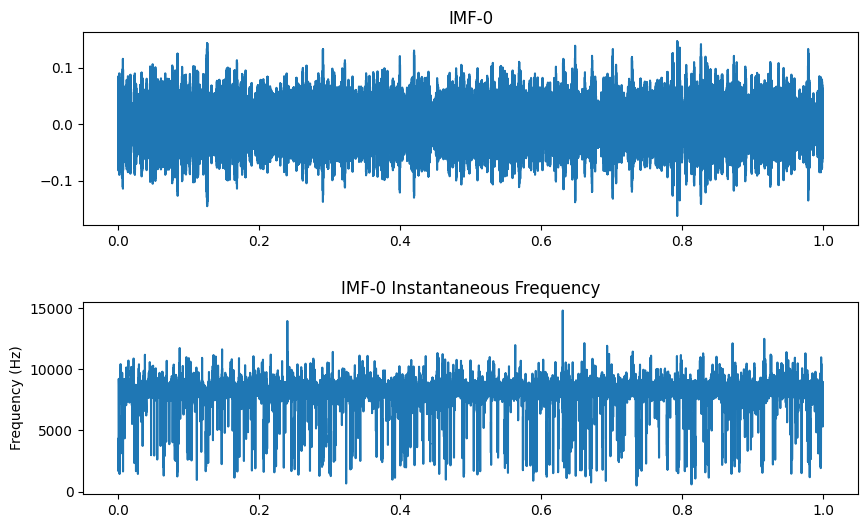

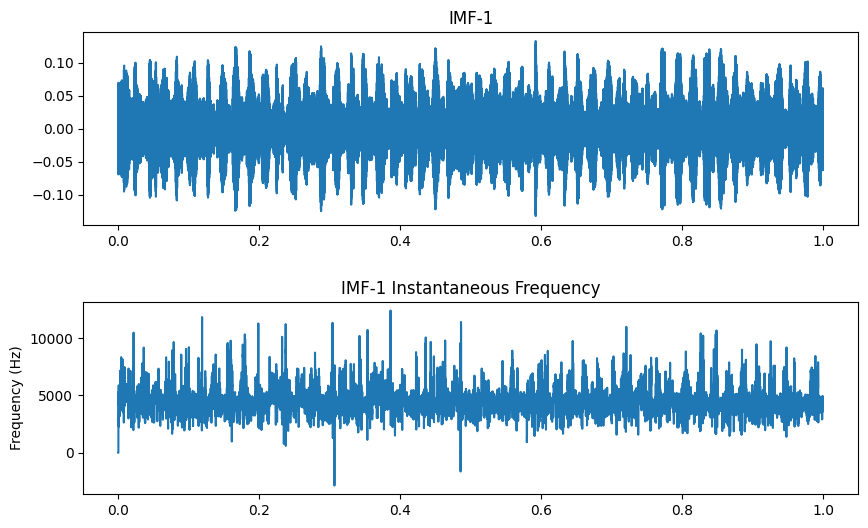

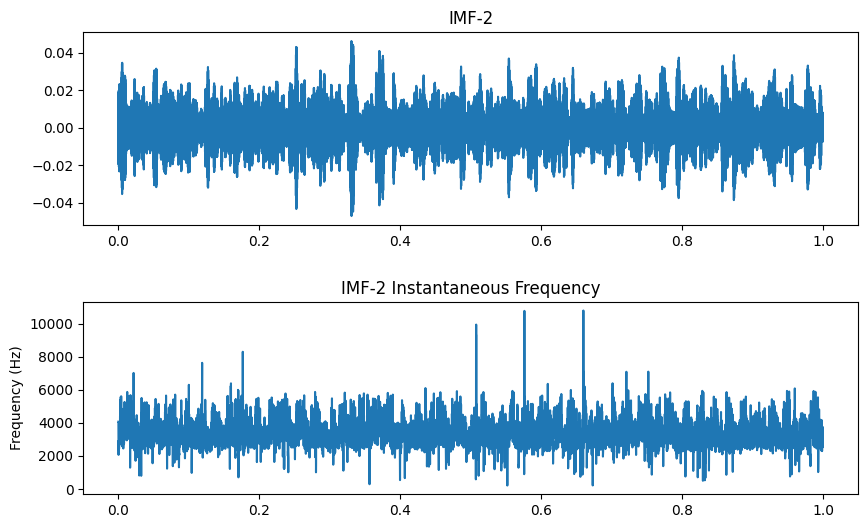

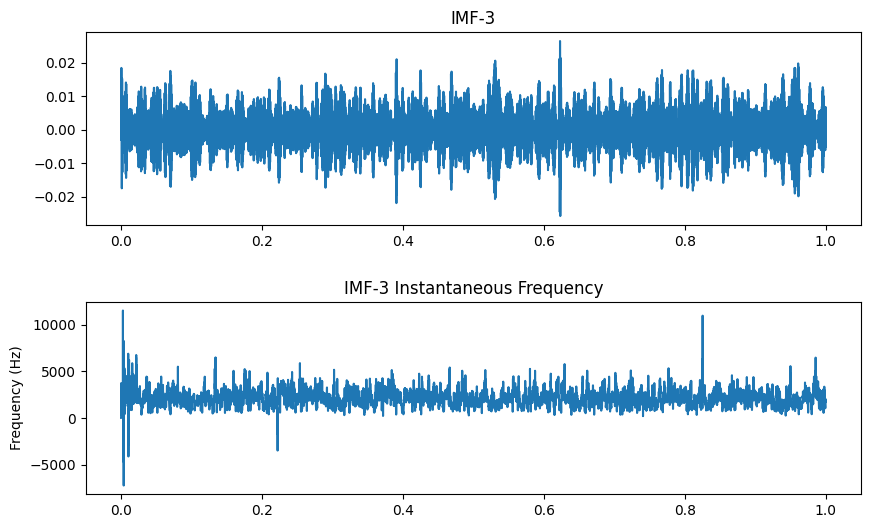

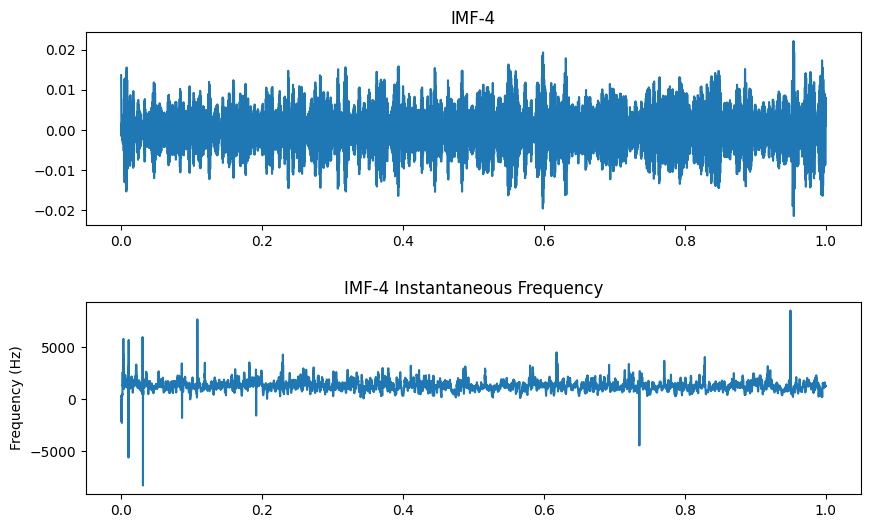

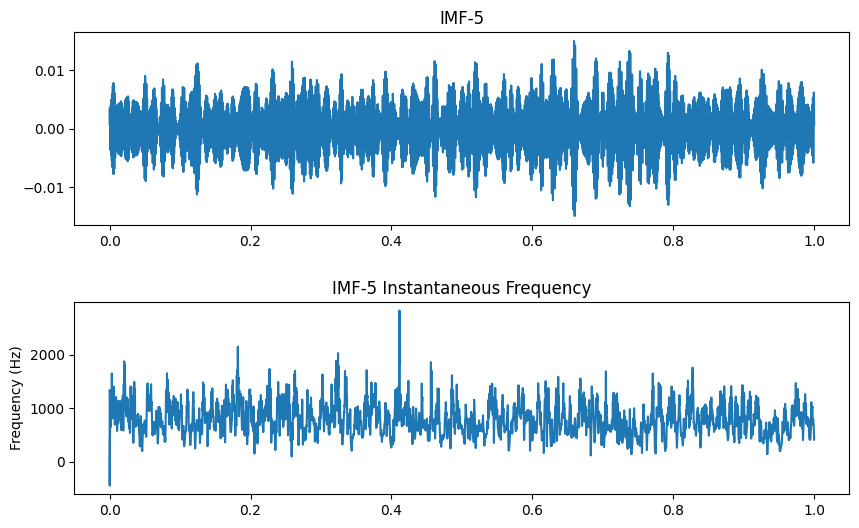

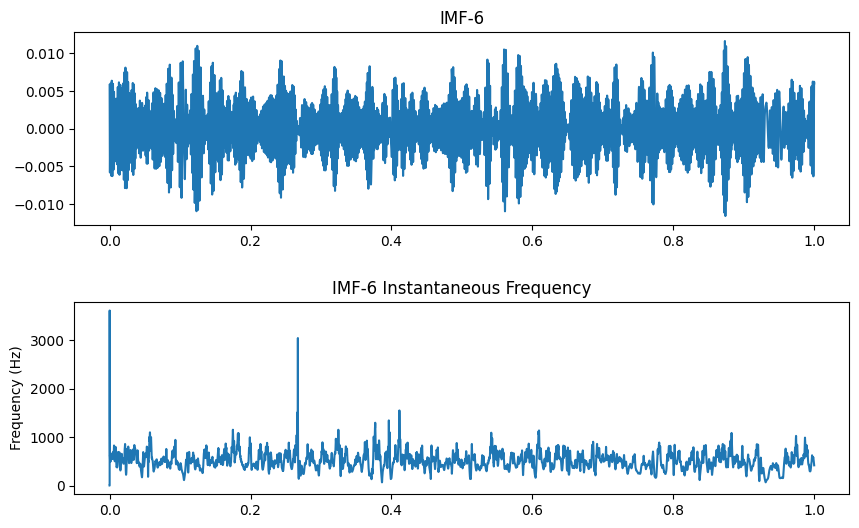

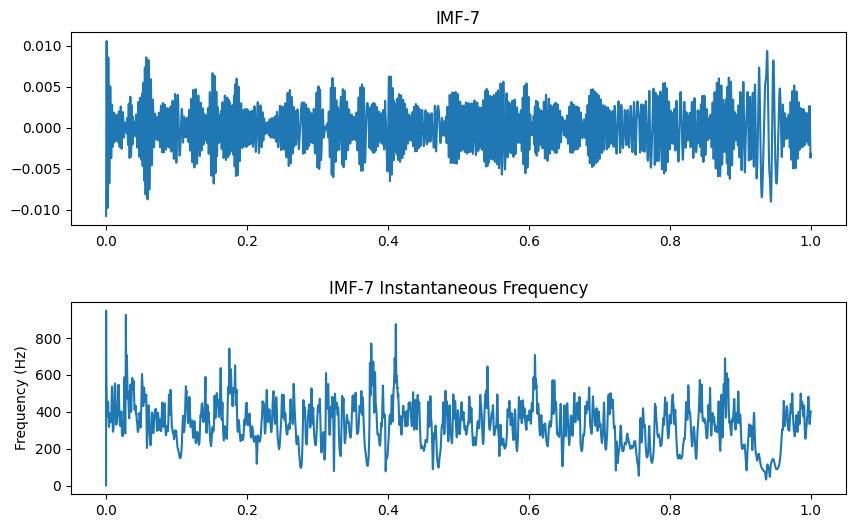

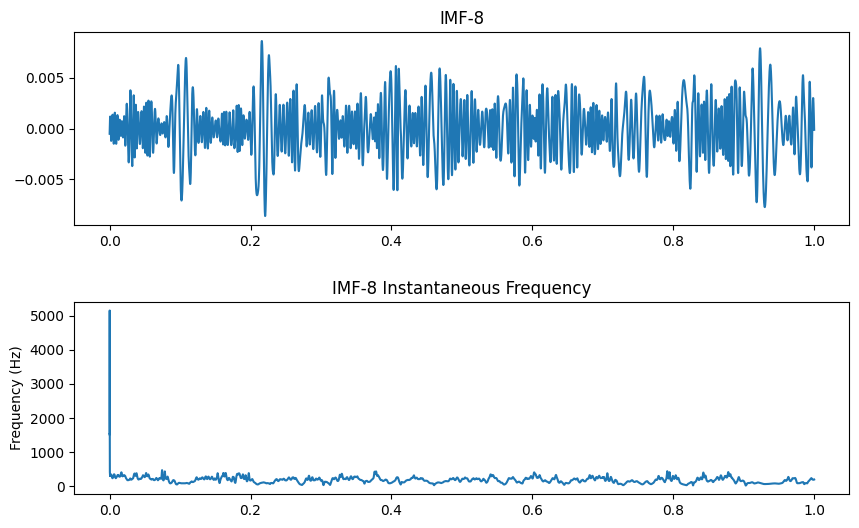

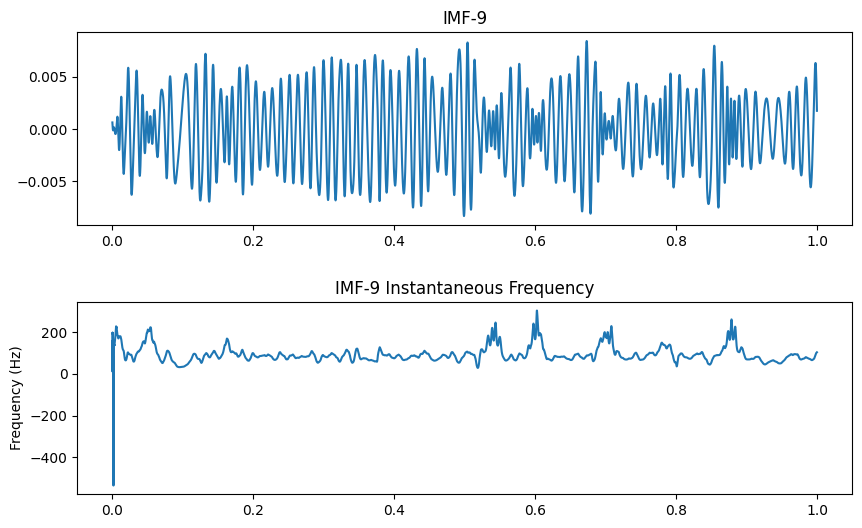

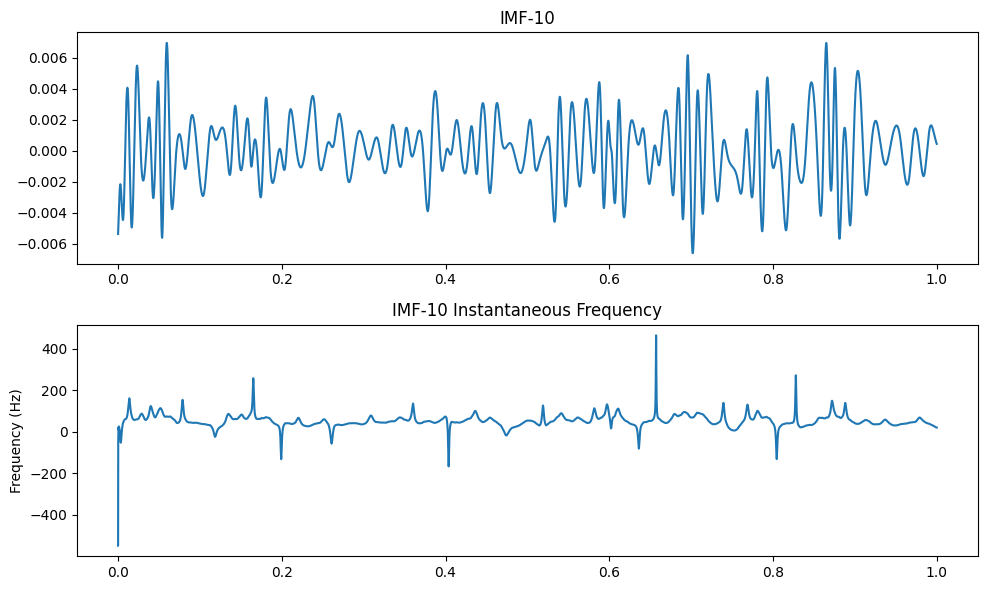

In [145]:
#plot the imf followed by its instantaneous frequencies
num_columns = imf.shape[1]

# Iterate over columns and plot
for i in range(num_columns):
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(hspace=0.4)
    plt.subplot(211)
    plt.plot(time_vect[:sr], imf[:sr, i])
    plt.title(f'IMF-{i}')
    plt.subplot(212)
    plt.plot(time_vect[:sr], IF[:sr, i])
    plt.title(f'IMF-{i} Instantaneous Frequency')
    plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

In [14]:
#create and write wav files for all of the imfs that were created
num_columns = imf.shape[1]

# Iterate over columns and plot
for i in range(num_columns):
    sf.write(f'C:\\Users\Alec\Desktop\GriffinEMD\d308sA3r04p04\IMF_{i}.wav', imf[:,i], sr)
    

In [15]:
os.chdir("C:\\Users\Alec\Desktop\GriffinEMD\d308sA3r04p04")

In [16]:
#function to sort the IMF files, necessary because when using glob if you have more than 10 IMFs they will be ordered
#IMF_0, IMF_1, IMF_10, ..., so sort them before summing them or recombining
import re
def extract_number(file_name):
    match = re.search(r'_(\d+)\.', file_name)
    if match:
        return int(match.group(1))
    else:
        return None

In [17]:
signal = glob('IMF*')

In [18]:
signal

['IMF_0.wav',
 'IMF_1.wav',
 'IMF_2.wav',
 'IMF_3.wav',
 'IMF_4.wav',
 'IMF_5.wav',
 'IMF_6.wav',
 'IMF_7.wav',
 'IMF_8.wav']

In [47]:
signal = sorted(signal, key=extract_number) #sort the file names

In [19]:
signal = signal[1:] #take a subset of the IMFs that you want to sum and create a wav file from

In [20]:
signal

['IMF_1.wav',
 'IMF_2.wav',
 'IMF_3.wav',
 'IMF_4.wav',
 'IMF_5.wav',
 'IMF_6.wav',
 'IMF_7.wav',
 'IMF_8.wav']

In [29]:
#create a wav file that is a combination of multiple IMFs
def read_wav(file_name):
    audio_data, _ = librosa.load(file_name, sr=None, mono=True)
    return audio_data

# Initialize sum of audio data
sum_audio = None

# Iterate over each file, read audio data and sum it
for file_name in signal:
    audio_data = read_wav(file_name)
    if sum_audio is None:
        sum_audio = audio_data
    else:
        sum_audio += audio_data

output_file = f"C:\\Users\Alec\Desktop\GriffinEMD\d308sA3r04p04\d308sA3r04p04_no_IMF0.wav"

sf.write(output_file, sum_audio, sr)

Testing different gain adjustment techniques to boost low frequencies, experimenting with hover scenarios

In [80]:
from scipy import signal

In [110]:
# Load your audio signal (replace with your own signal loading mechanism)
#y, sr = librosa.load("C:\\Users\Alec\Desktop\GriffinEMD\d306sA3r04SubsectionIMF\d306sA3r04_subsection.wav", sr=None)

# # Define the filter parameters
# cutoff_frequency = 1500  # Hz
# nyquist_frequency = sr / 2
# normalized_cutoff = cutoff_frequency / nyquist_frequency

# # Design a low-pass filter to boost frequencies below cutoff_frequency
# b, a = signal.butter(4, normalized_cutoff, btype='low')

# # Apply the filter to the signal
# filtered_signal = signal.filtfilt(b, a, y)

# # Plot the original and filtered signals
# plt.figure(figsize=(10, 6))
# plt.plot(y, label='Original Signal')
# plt.plot(filtered_signal, label='Boosted Signal (< 1500 Hz)')
# plt.title('Boosting Frequencies Below 1500 Hz')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid(True)
# plt.show()


# output_file = 'C:\\Users\Alec\Desktop\GriffinEMD\d306sA1r02p0320210824BOOSTED.wav'

# sf.write(output_file, filtered_signal, sr)

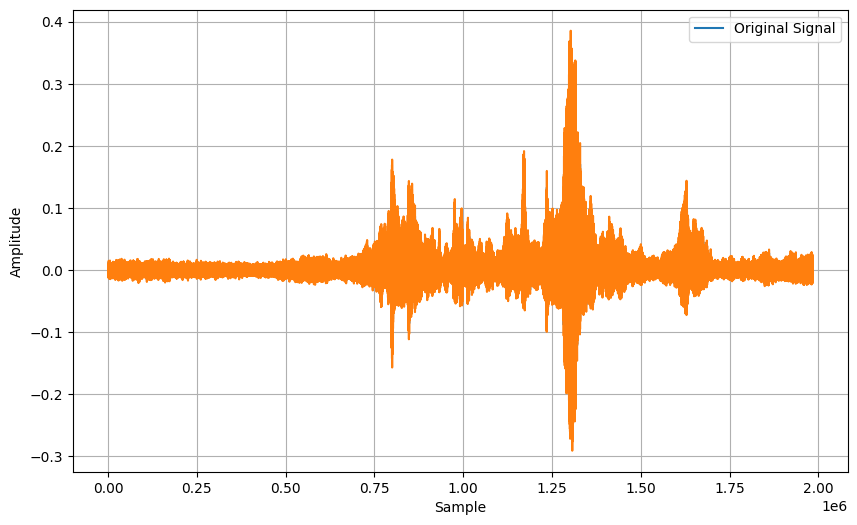

In [7]:
y, sr = librosa.load("C:\\Users\Alec\Desktop\GriffinEMD\contoured_d307sA2r04p0220210824_boosted.wav", sr=None)

# Define the filter parameters
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(y), 1/sr)

# Define the frequency range to boost
low_cutoff = 0  # Hz
high_cutoff = 3000  # Hz

# Create a mask to emphasize frequencies within the desired range
boost_mask = ((np.abs(freqs) >= low_cutoff) & (np.abs(freqs) <= high_cutoff)).astype(float)

# Emphasize frequencies within the desired range in the frequency domain
Y_boosted = Y * boost_mask

# Inverse Fourier Transform
emphasized_signal = np.fft.ifft(Y_boosted).real

emphasized_signal *= 20

emphasized_signal += y

# Plot the original and emphasized signals
plt.figure(figsize=(10, 6))
plt.plot(y, label='Original Signal')
plt.plot(emphasized_signal)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

output_file = 'C:\\Users\Alec\Desktop\GriffinEMD\d307sA2r04p0220210824_boosted.wav'

sf.write(output_file, emphasized_signal, sr)

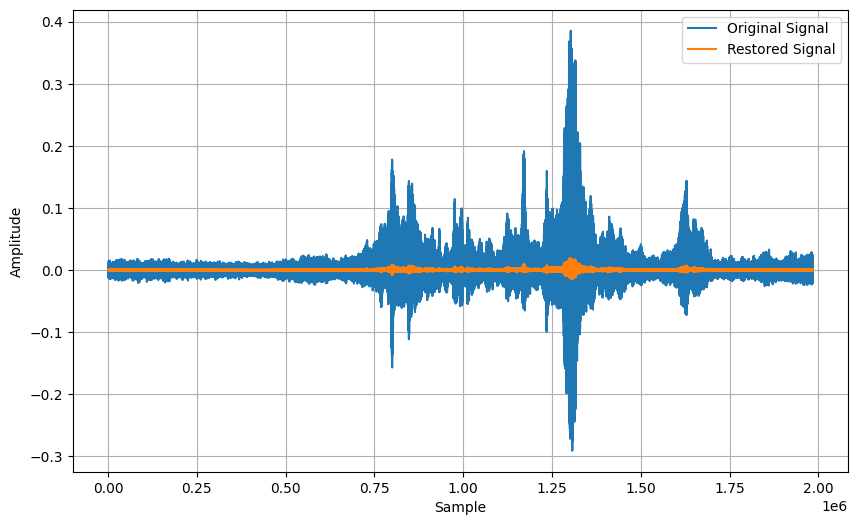

In [10]:
y, sr = librosa.load("C:\\Users\Alec\Desktop\GriffinEMD\contoured_d307sA2r04p0220210824_boosted.wav", sr=None)

#reverse the filter
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(y), 1/sr)

low_cutoff = 0  # Hz
high_cutoff = 8000  # Hz

# Create the boost mask again
boost_mask = ((np.abs(freqs) >= low_cutoff) & (np.abs(freqs) <= high_cutoff)).astype(float)

# Revert the filtering operation
Y_boosted = np.fft.fft(emphasized_signal)  # Take FFT of the emphasized signal

# Avoid division by zero (where boost_mask is zero)
boost_mask_safe = boost_mask.copy()
boost_mask_safe[boost_mask == 0] = 1.0  # Set zeros to 1 to avoid division by zero

# Divide by the boost_mask in the frequency domain to revert the filter
Y_restored = Y_boosted / (boost_mask_safe * 20)

# Inverse Fourier Transform to get the restored signal
restored_signal = np.fft.ifft(Y_restored).real

# Plot the original and restored signals
plt.figure(figsize=(10, 6))
plt.plot(y, label='Original Signal')
plt.plot(restored_signal, label='Restored Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

output_file = 'C:\\Users\Alec\Desktop\GriffinEMD\contoured_d307sA2r04p0220210824_boosted.wav'

sf.write(output_file, restored_signal, sr)